# Interoperability with `scirpy`
![dandelion_logo](img/dandelion_logo_illustration.png)

It is now possible to convert the file formats between `dandelion>=0.1.1` and `scirpy>=0.6.2` [[Sturm2020]](https://academic.oup.com/bioinformatics/article/36/18/4817/5866543) to enhance the collaboration between the analysis toolkits.

We will download the *airr_rearrangement.tsv* file from here:
```bash
# bash
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv
```


**Import *dandelion* module**

In [1]:
import os
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
ddl.logging.print_versions()

dandelion==0.2.2.dev82 pandas==1.4.2 numpy==1.21.6 matplotlib==3.5.2 networkx==2.8.4 scipy==1.8.1


In [2]:
import scirpy as ir
ir.__version__

'0.10.2.dev28+g2c5b99e'

## `dandelion`

In [3]:
# read in the airr_rearrangement.tsv file
file_location = 'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv'
vdj = ddl.read_10x_airr(file_location)
vdj

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'd_call_VDJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ', 'duplicate_count_VJ', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_1', 'duplicate_count_VDJ_2', 'duplicate_count_VJ_2', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'isotype', 'isotype_status', 'locus_status', 'productive_status',

The test file contains a blank `clone_id` column so we run `find_clones` to populate it first.

In [4]:
ddl.tl.find_clones(vdj)

Finding clones based on VDJ chains : 100%|██| 157/157 [00:00<00:00, 1310.83it/s]
Refining clone assignment based on VJ chain pairing : 100%|█| 978/978 [00:00<00:


### `ddl.to_scirpy` : Converting `dandelion` to `scirpy`

In [5]:
irdata = ddl.to_scirpy(vdj)
irdata

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir'
    uns: 'scirpy_version'

to transfer every column found in a dandelion airr object (including things like `germline_alignment_d_mask`) do:

In [6]:
irdata = ddl.to_scirpy(vdj, include_fields = vdj.data.columns)
irdata

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'is_cell', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_c_cigar', 'IR_VJ_2_c_cigar', 'IR_VDJ_1_c_cigar', 'IR_VDJ_2_c_cigar', 'IR_VJ_1_c_sequence_end', 'IR_VJ_2_c_sequence_end', 'IR_VDJ_1_c_sequence_end', 'IR_VDJ_2_c_sequence_end', 'IR_VJ_1_c_sequence_start', 'IR_VJ_2_c_sequence_start', 'IR_VDJ_1_c_sequence_start', 'IR_VDJ_2_c_sequence_start', 'IR_VJ_1_clone_id', 'IR_VJ_2_clone_id', 'IR_VDJ_1_clone_id', 'IR_VDJ_2_clone_id', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_d_cigar', 'IR_VJ_2_d_cigar', 'IR_VDJ_1_d_cigar', 'IR_VDJ_2_d_cigar', 'IR_VJ_1_d_sequence_end', 'IR_VJ_2_d_sequence_end', 'IR_VDJ_1_d_sequence_end', 'IR_VDJ_2_d_sequence_end', 'IR_VJ_1_d_sequence_start', 'IR_VJ_2_d_sequence_start', 'IR_VDJ_1_d_sequence_start

The `clone_id` is mapped to `IR_VJ_1_clone_id` column.

`transfer = True` will perform dandelion's `tl.transfer`.

In [7]:
irdatax = ddl.to_scirpy(vdj, transfer = True)
irdatax

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_V

### `ddl.from_scirpy` : Converting `scirpy` to `dandelion`

In [8]:
vdjx = ddl.from_scirpy(irdata)
vdjx

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'c_cigar', 'c_sequence_end', 'c_sequence_start', 'clone_id', 'consensus_count', 'd_sequence_end', 'd_sequence_start', 'duplicate_count', 'j_sequence_end', 'j_sequence_start', 'junction_aa_length', 'junction_length', 'locus', 'sequence_aa', 'v_sequence_end', 'v_sequence_start', 'cell_id', 'multi_chain', 'is_cell'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'd_call_VDJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ', 'duplicate_count_VJ', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_1', 'duplicate_count_VDJ_2', 'duplicate_count_VJ_2', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'isoty

In [9]:
vdjx.metadata

,clone_id,clone_id_by_size,locus_VDJ,locus_VJ,productive_VDJ,productive_VJ,v_call_VDJ,v_call_VJ,d_call_VDJ,j_call_VDJ,...,junction_aa_VDJ,junction_aa_VJ,isotype,isotype_status,locus_status,productive_status,rearrangement_VDJ_status,rearrangement_VJ_status,constant_VDJ_status,constant_VJ_status
AAACCTGTCATATCGG-1,None,None,None,IGK,None,True,None,IGKV1-8,None,None,...,None,CQQYDELPVTF,None,None,None + IGK,None + True,None,Single,None,Single
AAACCTGTCCGTTGTC-1,26_3_1_149_2_1,949,IGH,IGK,True,True,IGHV1-69D,IGKV1-8,IGHD3-22,IGHJ3,...,CATTYYYDSSGYYQNDAFDIW,CQQYYSYPRTF,IgM,IgM,IGH + IGK,True + True,Single,Single,Single,Single
AAACCTGTCGAGAACG-1,43_4_1_86_1_1,766,IGH,IGL,True,True,IGHV1-2,IGLV5-45,None,IGHJ3,...,CAREIEGDGVFEIW,CMIWHSSAWVV,IgM,IgM,IGH + IGL,True + True,Multi,Single,Single,Single
AAACCTGTCTTGAGAC-1,117_1_2_47_1_1,765,IGH,IGK,True,True,IGHV5-51,IGKV1D-8,None,IGHJ3,...,CARHIRGNRFGNDAFDIW,CQQYYSFPYTF,IgM,IgM,IGH + IGK,True + True,Multi,Single,Single,Single
AAACGGGAGCGACGTA-1,44_1_2_4_2_3,764,IGH,IGL,True,True,IGHV4-59,IGLV3-19,None,IGHJ3,...,CARVGYRAAAGTDAFDIW,CNSRDSSGNHVVF,IgM,IgM,IGH + IGL,True + True,Multi,Single,Single,Single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCTCTAACGGT-1,71_3_1_161_1_2,383,IGH,IGL,True,True,IGHV3-43,IGLV2-8,None,IGHJ6,...,CARVSGSYQYNYYYGMDVW,CGSFAGSNIWVF,IgM,IgM,IGH + IGL,True + True,Multi,Single,Single,Single
TTTGGTTGTAGCCTAT-1,34_1_1_163_2_1,382,IGH,IGK,True,True,IGHV4-39,IGKV6-21,None,IGHJ2,...,CARLWVFLTMVRGPDFDLW,CHQSSSLPLTF,IgM,IgM,IGH + IGK,True + True,Multi,Single,Single,Single
TTTGGTTTCAGAGCTT-1,131_5_2_96_1_1,381,IGH,IGK,True,True,IGHV7-4-1,IGKV3-11,IGHD3-10,IGHJ4,...,CARVFRRYGSGSYYNLW,CQQRSNWLTF,IgM,IgM,IGH + IGK,True + True,Single,Single,Single,Single
TTTGGTTTCAGTGTTG-1,59_1_1_88_2_1,380,IGH,IGL,True,True,IGHV2-5,IGLV2-23,None,IGHJ4,...,CAHRFEYFDYW,CCSYAGSSTFEVF,IgM,IgM,IGH + IGL,True + True,Multi,Single,Single,Single


## `scirpy`

### `ir.io.from_dandelion` : Converting `dandelion` to `scirpy`

In [10]:
irdata2 = ir.io.from_dandelion(vdj, include_fields = vdj.data.columns)
irdata2

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'is_cell', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_c_cigar', 'IR_VJ_2_c_cigar', 'IR_VDJ_1_c_cigar', 'IR_VDJ_2_c_cigar', 'IR_VJ_1_c_sequence_end', 'IR_VJ_2_c_sequence_end', 'IR_VDJ_1_c_sequence_end', 'IR_VDJ_2_c_sequence_end', 'IR_VJ_1_c_sequence_start', 'IR_VJ_2_c_sequence_start', 'IR_VDJ_1_c_sequence_start', 'IR_VDJ_2_c_sequence_start', 'IR_VJ_1_clone_id', 'IR_VJ_2_clone_id', 'IR_VDJ_1_clone_id', 'IR_VDJ_2_clone_id', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_d_cigar', 'IR_VJ_2_d_cigar', 'IR_VDJ_1_d_cigar', 'IR_VDJ_2_d_cigar', 'IR_VJ_1_d_sequence_end', 'IR_VJ_2_d_sequence_end', 'IR_VDJ_1_d_sequence_end', 'IR_VDJ_2_d_sequence_end', 'IR_VJ_1_d_sequence_start', 'IR_VJ_2_d_sequence_start', 'IR_VDJ_1_d_sequence_start

likewise, `transfer = True` will perform dandelion's `tl.transfer`.

In [11]:
irdata2x = ir.io.from_dandelion(vdj, transfer = True, include_fields = vdj.data.columns)
irdata2x

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'is_cell', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_c_cigar', 'IR_VJ_2_c_cigar', 'IR_VDJ_1_c_cigar', 'IR_VDJ_2_c_cigar', 'IR_VJ_1_c_sequence_end', 'IR_VJ_2_c_sequence_end', 'IR_VDJ_1_c_sequence_end', 'IR_VDJ_2_c_sequence_end', 'IR_VJ_1_c_sequence_start', 'IR_VJ_2_c_sequence_start', 'IR_VDJ_1_c_sequence_start', 'IR_VDJ_2_c_sequence_start', 'IR_VJ_1_clone_id', 'IR_VJ_2_clone_id', 'IR_VDJ_1_clone_id', 'IR_VDJ_2_clone_id', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_d_cigar', 'IR_VJ_2_d_cigar', 'IR_VDJ_1_d_cigar', 'IR_VDJ_2_d_cigar', 'IR_VJ_1_d_sequence_end', 'IR_VJ_2_d_sequence_end', 'IR_VDJ_1_d_sequence_end', 'IR_VDJ_2_d_sequence_end', 'IR_VJ_1_d_sequence_start', 'IR_VJ_2_d_sequence_start', 'IR_VDJ_1_d_sequence_start

### `ir.io.to_dandelion` : Converting `scirpy` to `dandelion`

In [12]:
vdj3 = ir.io.to_dandelion(irdata2)
vdj3

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'c_cigar', 'c_sequence_end', 'c_sequence_start', 'clone_id', 'consensus_count', 'd_sequence_end', 'd_sequence_start', 'duplicate_count', 'j_sequence_end', 'j_sequence_start', 'junction_aa_length', 'junction_length', 'locus', 'sequence_aa', 'v_sequence_end', 'v_sequence_start', 'cell_id', 'multi_chain', 'is_cell'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'd_call_VDJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ', 'duplicate_count_VJ', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_1', 'duplicate_count_VDJ_2', 'duplicate_count_VJ_2', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'isoty

### Example of reading with `scirpy` followed by conversion to `dandelion`

In [13]:
# read in the airr_rearrangement.tsv file
file_location = 'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv'
irdata_s = ir.io.read_airr(file_location)
irdata_s

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir'
    uns: 'scirpy_version'

This time, find clones with `scirpy`'s method.

In [14]:
ir.tl.chain_qc(irdata_s)
ir.pp.ir_dist(irdata_s, metric = 'hamming', sequence="aa")
ir.tl.define_clonotypes(irdata_s)
irdata_s

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/984 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 994 × 0
    obs: 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'receptor_type', 'receptor_subtype', 'chain_pairing',

In [15]:
vdj4 = ir.io.to_dandelion(irdata_s)
vdj4

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'consensus_count', 'duplicate_count', 'locus', 'cell_id', 'multi_chain', 'clone_id_size', 'clone_id', 'receptor_type', 'receptor_subtype', 'chain_pairing'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'd_call_VDJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ', 'duplicate_count_VJ', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_1', 'duplicate_count_VDJ_2', 'duplicate_count_VJ_2', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'isotype', 'isotype_status', 'locus_status', 'productive_status', 'rearrangement_VDJ_status', 'rearrangement_VJ_status', 'constant_VDJ_status', 'constant_VJ_status'


### Visualising with `scirpy`'s plotting tools

You can now also plot `dandelion` networks using `scirpy`'s functions.

In [16]:
ddl.tl.generate_network(vdj, key = 'junction')

Setting up data: 2093it [00:00, 6026.30it/s]
Linking edges : 100%|██████████████████████| 969/969 [00:00<00:00, 41775.76it/s]


generating network layout
To benefit from faster layout computation, please install graph-tool: conda install -c conda-forge graph-tool


In [17]:
irdata_s.obs['scirpy_clone_id'] = irdata_s.obs['clone_id'] # stash it
ddl.tl.transfer(irdata_s, vdj, overwrite = True) # overwrite scirpy's clone_id definition

converting matrices
Updating anndata slots


<AxesSubplot:>

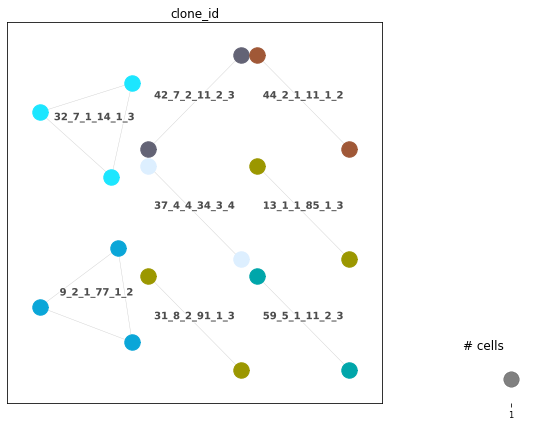

In [18]:
ir.tl.clonotype_network(irdata_s, min_cells = 2)
ir.pl.clonotype_network(irdata_s, color = 'clone_id', panel_size=(7,7))

to swap to a shorter clone_id name (ordered by size)

converting matrices
Updating anndata slots


<AxesSubplot:>

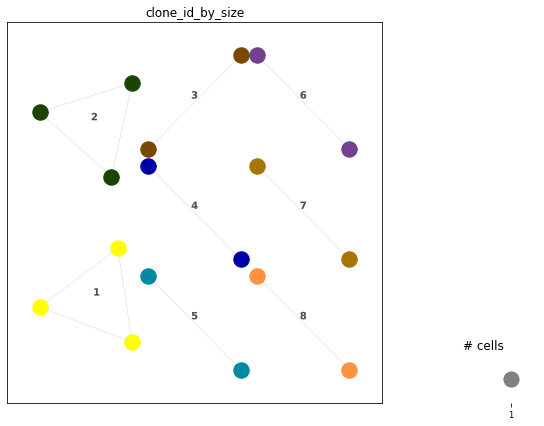

In [19]:
ddl.tl.transfer(irdata_s, vdj, clone_key = 'clone_id_by_size')
ir.tl.clonotype_network(irdata_s, clonotype_key= 'clone_id_by_size', min_cells = 2)
ir.pl.clonotype_network(irdata_s, color = 'clone_id_by_size', panel_size=(7,7))

you can also collapse the networks to a single node and plot by size

converting matrices
Updating anndata slots


<AxesSubplot:>

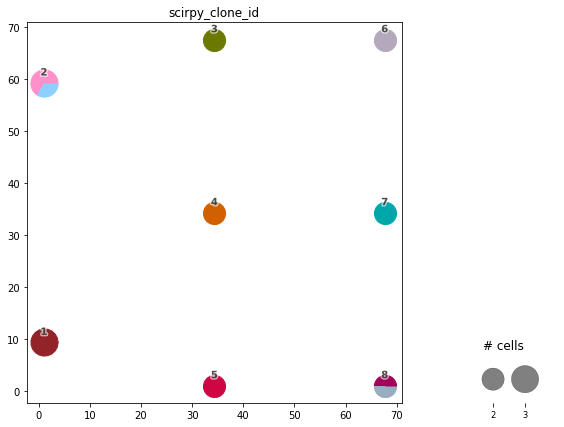

In [20]:
ddl.tl.transfer(irdata_s, vdj, clone_key = 'clone_id_by_size', collapse_nodes = True)
ir.tl.clonotype_network(irdata_s, clonotype_key = 'clone_id_by_size', min_cells = 2)
ir.pl.clonotype_network(irdata_s, color = 'scirpy_clone_id', panel_size=(7,7))